# Traffic classification - DDoS or benign.

Log research of IDS systems (Intrusion Detection System) for 
detection of abnormal traffic using machine learning.

DDoS data extracted from different public IDS's and concatenated with benign (normal) traffic flows. 

Base datasets:
1. `CSE-CIC-IDS2018-AWS`: https://www.unb.ca/cic/datasets/ids-2017.html
2. `CICIDS2017`: https://www.unb.ca/cic/datasets/ids-2018.html
3. `CIC DoS dataset(2016)`: https://www.unb.ca/cic/datasets/dos-dataset.html

## Download dataset. Import libraries.

In [69]:
# Use 1.6.17, because in the recently released v1.7.4 appeared an error in the `download` method.
! pip install kaggle==1.6.17 -q

In [70]:
! kaggle datasets files devendra416/ddos-datasets

name                                         size  creationDate         
-------------------------------------------  ----  -------------------  
ddos_balanced/final_dataset.csv               6GB  2019-04-30 13:57:07  
ddos_imbalanced/unbalaced_20_80_dataset.csv   4GB  2019-04-30 13:58:15  


In [71]:
! kaggle datasets download -d "devendra416/ddos-datasets" -f "ddos_balanced/final_dataset.csv" -p "./content/" -q

Dataset URL: https://www.kaggle.com/datasets/devendra416/ddos-datasets
License(s): other


In [72]:
import zipfile
import os

CSV_PATH = './content/final_dataset.csv'

if not os.path.exists(CSV_PATH):
    print('Extracting dataset...')
    with zipfile.ZipFile('./content/final_dataset.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('./content/')
    print('Success.')
else:
    print('Dataset already extracted.')

Dataset already extracted.


In [73]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

## Read dataset.

In [74]:
def get_dtypes() -> dict:
    """Return optimal data types for each column."""
    # Timestamp is not included as it will be parsed later.
    return {
        'Src IP': 'category',          # Source IP address (text).
        'Src Port': 'uint16',          # Source port (integer in [0, 65535]).
        'Dst IP': 'category',          # Destination IP (text).
        'Dst Port': 'uint16',          # Destination port (integer in [0, 65535]).
        'Protocol': 'category',        # Protocol type (3 categories).
        'Flow Duration': 'uint32',     # Duration of flow in ms.
        'Tot Fwd Pkts': 'uint32',      # Total forward-packets count.
        'Tot Bwd Pkts': 'uint32',      # Total backward-packets count.
        'TotLen Fwd Pkts': 'float32',  # Total forward-packets length in bytes.
        'TotLen Bwd Pkts': 'float32',  # Total backward-packets length in bytes.
        'Fwd Pkt Len Max': 'float32',  # Max forward-packets length in bytes.
        'Fwd Pkt Len Min': 'float32',  # Min forward-packets length in bytes.
        'Fwd Pkt Len Mean': 'float32', # Mean forward-packets length in bytes.
        'Fwd Pkt Len Std': 'float32',  # Standard deviation of forward-packets length in bytes.
        'Bwd Pkt Len Max': 'float32',  # Max backward-packets length in bytes.
        'Bwd Pkt Len Min': 'float32',  # Min backward-packets length in bytes.
        'Bwd Pkt Len Mean': 'float32', # Mean backward-packets length in bytes.
        'Bwd Pkt Len Std': 'float32',  # Standard deviation of backward-packets length in bytes.
        'Flow Byts/s': 'float32',      # Speed of flow in bytes per second.
        'Flow Pkts/s': 'float32',      # Speed of flow in packets per second.
        'Flow IAT Mean': 'float32',    # Mean time between packets in flow.
        'Flow IAT Std': 'float32',     # Standard deviation of time between packets in flow.
        'Flow IAT Max': 'float32',     # Max time between packets in flow.
        'Flow IAT Min': 'float32',     # Min time between packets in flow.
        'Fwd IAT Tot': 'float32',      # Total time between packets in forward direction.
        'Fwd IAT Mean': 'float32',     # Mean time between packets in forward direction.
        'Fwd IAT Std': 'float32',      # STD of time between packets in forward direction.
        'Fwd IAT Max': 'float32',      # Max time between packets in forward direction.
        'Fwd IAT Min': 'float32',      # Min time between packets in forward direction.
        'Bwd IAT Tot': 'float32',      # Total time between packets in backward direction.
        'Bwd IAT Mean': 'float32',     # Mean time between packets in backward direction.
        'Bwd IAT Std': 'float32',      # STD of time between packets in backward direction.
        'Bwd IAT Max': 'float32',      # Max time between packets in backward direction.
        'Bwd IAT Min': 'float32',      # Min time between packets in backward direction.
        'Fwd PSH Flags': 'uint8',      # PSH flags in forward direction.
        'Bwd PSH Flags': 'uint8',      # PSH flags in backward direction.
        'Fwd URG Flags': 'uint8',      # URG flags in forward direction.
        'Bwd URG Flags': 'uint8',      # URG flags in backward direction.
        'Fwd Header Len': 'uint32',    # Header length in forward direction.
        'Bwd Header Len': 'uint32',    # Header length in backward direction.
        'Fwd Pkts/s': 'float32',       # Speed of forward packets flow in packets per second.
        'Bwd Pkts/s': 'float32',       # Speed of backward packets flow in packets per second.
        'Pkt Len Min': 'float32',      # Min packet length in flow.
        'Pkt Len Max': 'float32',      # Max packet length in flow.
        'Pkt Len Mean': 'float32',     # Mean packet length in flow.
        'Pkt Len Std': 'float32',      # STD packet length in flow.
        'Pkt Len Var': 'float32',      # Variance of packet length in flow.
        'FIN Flag Cnt': 'uint8',       # Count of FIN flags.
        'SYN Flag Cnt': 'uint8',       # Count of SYN flags.
        'RST Flag Cnt': 'uint8',       # Count of RST flags.
        'PSH Flag Cnt': 'uint8',       # Count of PSH flags.
        'ACK Flag Cnt': 'uint8',       # Count of ACK flags.
        'URG Flag Cnt': 'uint8',       # Count of URG flags.
        'CWE Flag Count': 'uint8',     # Count of CWE flags.
        'ECE Flag Cnt': 'uint8',       # Count of ECE flags.
        'Down/Up Ratio': 'float32',    # Ratio of incoming to outgoing traffic.
        'Pkt Size Avg': 'float32',     # Average packet size in flow.
        'Fwd Seg Size Avg': 'float32', # Average segment size in forward direction.
        'Bwd Seg Size Avg': 'float32', # Average segment size in backward direction.
        'Fwd Byts/b Avg': 'uint32',    # Average bytes per packet in forward direction.
        'Fwd Pkts/b Avg': 'uint32',    # Average packets per byte in forward direction.
        'Fwd Blk Rate Avg': 'uint32',  # Average block rate in forward direction.
        'Bwd Byts/b Avg': 'uint32',    # Average bytes per packet in backward direction.
        'Bwd Pkts/b Avg': 'uint32',    # Average packets per byte in backward direction.
        'Bwd Blk Rate Avg': 'uint32',  # Average block rate in backward direction.
        'Subflow Fwd Pkts': 'uint32',  # Number of packets in subflow in forward direction.
        'Subflow Fwd Byts': 'uint32',  # Number of bytes in subflow in forward direction.
        'Subflow Bwd Pkts': 'uint32',  # Number of packets in subflow in backward direction.
        'Subflow Bwd Byts': 'uint32',  # Number of bytes in subflow in backward direction.
        'Init Fwd Win Byts': 'uint32', # Initial window size in forward direction.
        'Init Bwd Win Byts': 'uint32', # Initial window size in backward direction.
        'Fwd Act Data Pkts': 'uint32', # Number of data packets in forward direction.
        'Fwd Seg Size Min': 'uint32',  # Min segment size in forward direction.
        'Active Mean': 'float32',      # Mean active time in flow.
        'Active Std': 'float32',       # Standard deviation of active time.
        'Active Max': 'float32',       # Max active time.
        'Active Min': 'float32',       # Min active time.
        'Idle Mean': 'float32',        # Mean idle time in flow.
        'Idle Std': 'float32',         # Standard deviation of idle time.
        'Idle Max': 'float32',         # Max idle time.
        'Idle Min': 'float32',         # Min idle time.
        'Label': 'category'            # Label (e.g., DDoS or Benign).
    }

In [75]:
def get_df_info_str(dataframe: pd.DataFrame) -> str:
    """Return DataFrame shape and memory usage formatted string."""
    mem = round(dataframe.memory_usage().sum() / 1024**2, 2)
    return f'\t Shape: {dataframe.shape}\n\tMemory: {mem} MB'

In [76]:
def parse_timestamp(timestamp_str: str) -> datetime:
    """Return parsed timestamp as datetime object."""
    fmt = '%d/%m/%Y %I:%M:%S'
    if timestamp_str[-2:] in ['AM', 'PM']:
        fmt += ' %p'
    return datetime.strptime(timestamp_str, fmt)

In [77]:
# Read dataset.
PARQUET_PATH = CSV_PATH[:-4] + '.parquet'
FORCE_REWRITE = False  # Set True to rewrite parquet file.

# Read dataset if parquet file does not exist.
if FORCE_REWRITE or not os.path.exists(PARQUET_PATH):
    
    CHUNK_SIZE = 100_000  # Read {CHUNK_SIZE} rows at a time.
    FRAC = 0.25  # Use 25% of dataset (about 1.5GB of RAM).
    ROWS_COUNT = 12_700_000  # Approximate dataset size.
    
    chunks = []
    dtypes = get_dtypes()
    print('Reading CSV...')
    for i, chunk in enumerate(pd.read_csv(
            CSV_PATH,
            dtype=dtypes,
            parse_dates=['Timestamp'],
            date_parser=parse_timestamp,
            engine='c',
            low_memory=True,
            chunksize=CHUNK_SIZE
    )):
        chunk_ = chunk.sample(frac=FRAC, random_state=0)
        chunks.append(chunk_)
        print(f'Read: {int(i*CHUNK_SIZE / 1e3)}k '
              f'of {int(ROWS_COUNT / 1e3)}k\t'
              f'Used: {int(i*CHUNK_SIZE*FRAC / 1e3)}k',
              end='\r')
    
    print('\nRead.\nConcatenating...')
    df = pd.concat(chunks)
    del dtypes
    del chunks

    print(f'Concatenated.\n{get_df_info_str(df)}\nConverting into parquet...')
    df.to_parquet(PARQUET_PATH)
    print(f'Converted.\nDF saved into `{PARQUET_PATH}`.')

print(f'Reading from parquet...')
df = pd.read_parquet(PARQUET_PATH)
print(f'Read.\n{get_df_info_str(df)}')

Reading from parquet...
Read.
	 Shape: (3198657, 85)
	Memory: 1024.96 MB


## Preprocessing.

### Pre-analysis.

In [78]:
df.sample(5, random_state=0)

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
12388875,6426326,172.31.65.68-62.146.70.120-445-62494-6,62.146.70.120,62494,172.31.65.68,445,6,2018-02-20 11:34:15,104135,3,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3129205,278540,172.31.69.25-18.219.193.20-80-59464-6,18.219.193.20,59464,172.31.69.25,80,6,2018-02-16 23:16:36,25067,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2502067,227593,172.31.69.25-18.219.5.43-80-54451-6,18.219.5.43,54451,172.31.69.25,80,6,2018-02-20 10:21:27,9990720,2,...,20,0.0,0.0,0.0,0.0,9990720.0,0.0,9990720.0,9990720.0,ddos
6307514,3456849,172.31.69.25-18.219.193.20-80-34166-6,172.31.69.25,80,18.219.193.20,34166,6,2018-02-16 23:27:06,4367247,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
598118,491559,172.31.69.28-18.219.9.1-80-55063-6,18.219.9.1,55063,172.31.69.28,80,6,2018-02-21 23:54:49,593,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [79]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Unnamed: 0,3198657.0,NaN,NaN,NaN,2663100.37692,0.0,898504.0,2041665.0,3906515.0,7902473.0,2170006.252904
Flow ID,3198657,1719404,8.0.6.4-8.6.0.1-0-0-0,18908,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Src IP,3198657,25152,172.31.69.25,441858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Src Port,3198657.0,NaN,NaN,NaN,37062.017538,0.0,443.0,50590.0,56224.0,65535.0,25223.515196
Dst IP,3198657,24501,172.31.69.25,621315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Idle Mean,3198657.0,NaN,NaN,NaN,3119173.25,0.0,0.0,0.0,0.0,119988720.0,12190516.0
Idle Std,3198657.0,NaN,NaN,NaN,109250.890625,0.0,0.0,0.0,0.0,73978656.0,1415605.5
Idle Max,3198657.0,NaN,NaN,NaN,3214718.75,0.0,0.0,0.0,0.0,119988720.0,12442321.0
Idle Min,3198657.0,NaN,NaN,NaN,3018433.25,0.0,0.0,0.0,0.0,119988720.0,12062840.0


In [80]:
# There's some inf values in the columns which can't be true.
df.replace({'Flow Byts/s': np.inf, 'Flow Pkts/s': np.inf}, np.nan, inplace=True)

In [81]:
# Look for NaN values.
missing = df.columns[df.isna().any()]
print(f'Missing values:')
for col in missing:
    print(f'\t{col}: {df[col].isna().sum()} | {df[col].isna().sum() / df.shape[0]:.2%} of {df.shape[0]} rows')

Missing values:
	Flow Byts/s: 11891 | 0.37% of 3198657 rows
	Flow Pkts/s: 11891 | 0.37% of 3198657 rows


In [82]:
# Look for dominance % of one value in binary columns.
cols_with_2_unique = [col for col in df.columns if df[col].nunique() == 2 and col != 'Label']
col_val_dominance = [
    [
        col,
        df[col].value_counts(normalize=True).idxmax(),
        df[col].value_counts(normalize=True).max()
    ] for col in cols_with_2_unique
]

for col, value, dominance in sorted(col_val_dominance, reverse=True, key=lambda x: x[2]):
    print(f'{col}: {value} \t| {dominance:.2%} dominance')

Bwd PSH Flags: 0 	| 99.76% dominance
FIN Flag Cnt: 0 	| 98.45% dominance
URG Flag Cnt: 0 	| 98.09% dominance
Fwd PSH Flags: 0 	| 97.14% dominance
CWE Flag Count: 0 	| 91.54% dominance
RST Flag Cnt: 0 	| 88.91% dominance
SYN Flag Cnt: 0 	| 86.41% dominance
ECE Flag Cnt: 0 	| 80.55% dominance
PSH Flag Cnt: 0 	| 79.89% dominance
ACK Flag Cnt: 1 	| 51.08% dominance


### Clean data.

Properties that can be deleted:
- `Unnamed: 0` - Just an ID;
- `Flow ID` - Union of `SRC IP`, `DST IP`, `SRC Port`, `DST Port`;
- `Bwd URG Flags` & `Fwd URG Flags` - Only one unique value;
- Some of the cols with 2 unique values as they have over 90% of one value dominance:
`[CWE Flag Count,
  URG Flag Cnt,
  ACK Flag Cnt,
  PSH Flag Cnt,
  RST Flag Cnt,
  SYN Flag Cnt,
  FIN Flag Cnt,
  Bwd PSH Flags,
  Fwd PSH Flags,
  ECE Flag Cnt]`;

And some (less than 0.5%) of the rows with NaN values.

In [83]:
# Proceed clean-up.
print(f'Before:\n{get_df_info_str(df)}\nCleaning...')

# Delete useless columns.
cols_to_drop = ['Unnamed: 0', 'Flow ID', 'Bwd URG Flags', 'Fwd URG Flags']
df = df.drop(columns=cols_to_drop)
print(f'Dropped: {cols_to_drop}')

# Delete columns with {DOM_THRESHOLD} dominance of one value.
DOM_THRESHOLD = 0.9
cols_to_drop = [col for col, _, dom in col_val_dominance if dom > DOM_THRESHOLD]
df = df.drop(columns=cols_to_drop)
print(f'Dropped: {cols_to_drop}')

# Delete rows with missing values.
missing_count = df.isna().any(axis=1).sum()
df = pd.DataFrame(df.dropna(), columns=df.columns)
print(f'Dropped: {missing_count} rows with missing values')

del DOM_THRESHOLD, col_val_dominance
del cols_to_drop
del missing, missing_count

print(f'Cleaned-up.\nAfter:\n{get_df_info_str(df)}')

Before:
	 Shape: (3198657, 85)
	Memory: 1024.96 MB
Cleaning...
Dropped: ['Unnamed: 0', 'Flow ID', 'Bwd URG Flags', 'Fwd URG Flags']
Dropped: ['Fwd PSH Flags', 'Bwd PSH Flags', 'FIN Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count']
Dropped: 11891 rows with missing values
Cleaned-up.
After:
	 Shape: (3186766, 76)
	Memory: 951.25 MB


In [84]:
df.sample(5, random_state=0)

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
11653716,192.168.10.3,60669,192.168.10.1,53,17,2017-07-03 20:09:42,47199,0,2,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
9126493,172.31.69.10,445,46.98.134.198,56397,6,2018-02-20 05:44:47,1280,2,0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
856710,18.216.200.189,61712,172.31.69.28,80,6,2018-02-22 00:06:26,2230,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
8064643,212.92.116.6,61405,172.31.64.88,3389,6,2018-02-20 03:20:28,12619299,9,9,1821.0,...,20,235271.0,0.0,235271.0,235271.0,10455234.0,0.0,10455234.0,10455234.0,Benign
2998815,18.219.193.20,39756,172.31.69.25,80,6,2018-02-16 23:15:38,1058,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


### Analysis.

In [85]:
# Replace 'Label' with bool 'Is ddos' column.
df['Is ddos'] = np.where(df['Label'] == 'ddos', 1, 0)
df = df.drop(columns=['Label', ])

TARGET_COL = 'Is ddos'

In [86]:
# Show distribution of target class.
print(round(df[TARGET_COL].value_counts(normalize=True) * 100, 2))

Is ddos
1    50.78
0    49.22
Name: proportion, dtype: float64


In [87]:
# Balance distribution of target class.
df_ddos_balanced = df[df[TARGET_COL] == 1].sample(
    n=df[TARGET_COL].value_counts()[0], 
    random_state=0
)
df = pd.concat([df_ddos_balanced, df[df[TARGET_COL] == 0]], axis=0)

del df_ddos_balanced

print(f'Target class distribution\n{df[TARGET_COL].value_counts(normalize=True) * 100}')

Target class distribution
Is ddos
1    50.0
0    50.0
Name: proportion, dtype: float64


Is ddos        0        1
Protocol                 
0          28962        0
17        546832     1013
6         992773  1567554


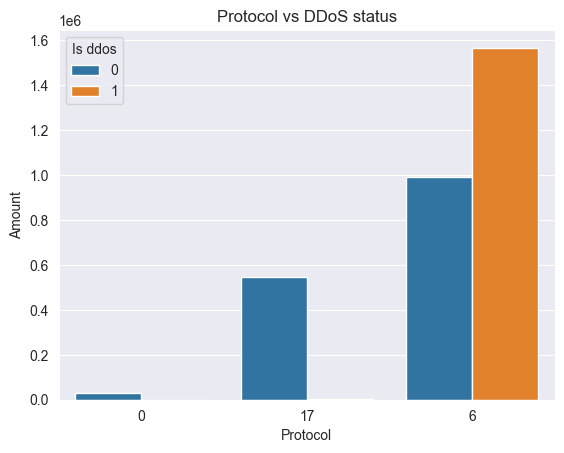

In [88]:
# Relation between Protocol and DDoS status.
cross = pd.crosstab(index=df['Protocol'], columns=df['Is ddos'])
print(cross)

stacked = cross.stack().reset_index().rename(columns={0: 'Amount'})
sns.barplot(
    x=stacked['Protocol'],
    y=stacked['Amount'],
    hue=stacked['Is ddos']
)
plt.title(f'Protocol vs DDoS status')

del cross
del stacked

plt.show()

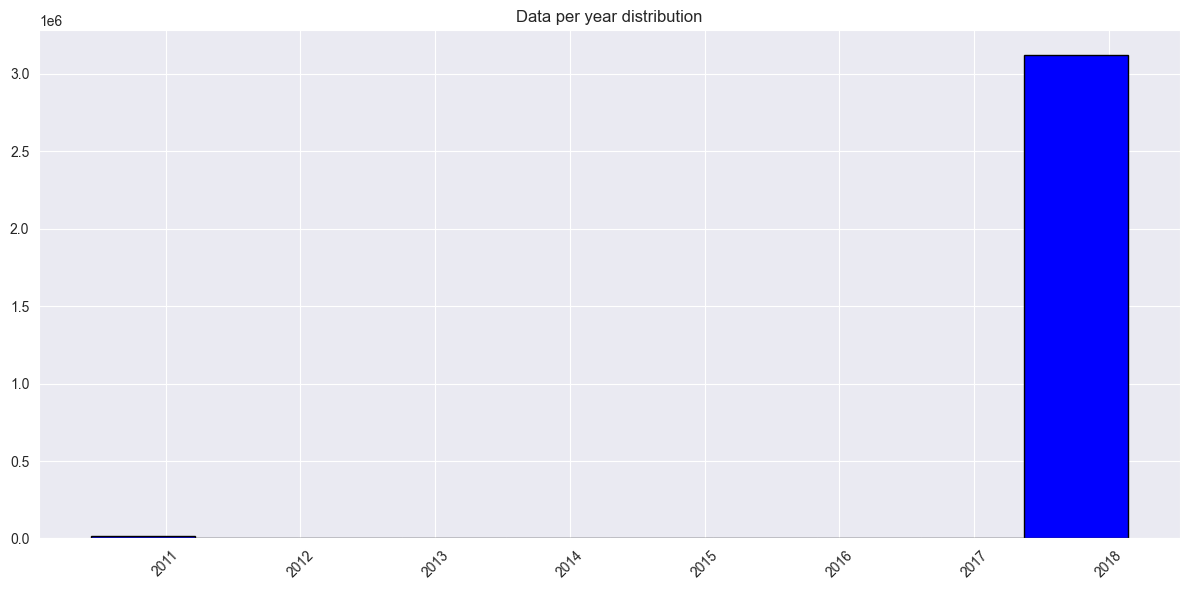

In [89]:
# Show Timestamp distribution.
plt.figure(figsize=(12, 6))
plt.hist(df['Timestamp'], color='blue', edgecolor='black')
plt.title('Data per year distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

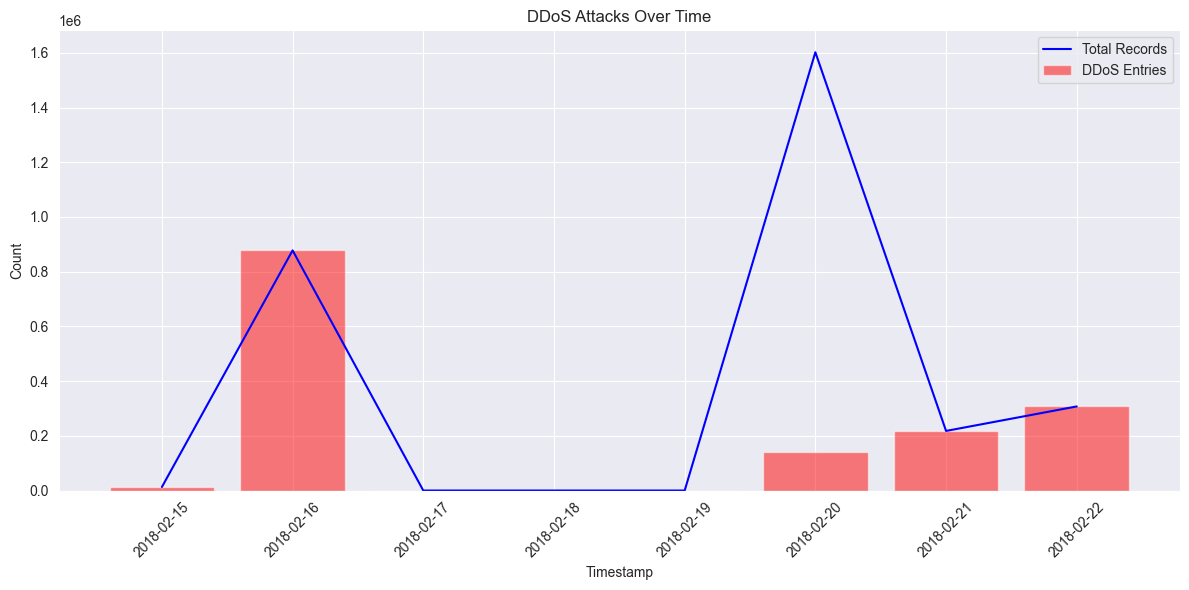

In [90]:
# The vast majority of records were made in 2018.

# Show DDoS/Time correlation in 2018:
# - Linear plot: Timestamp distribution;
# - Bar plot: DDoS entries at the Timestamp.

# DF filtered by Timestamp.year == 2018, grouped by Timestamp.
ts_2018 = df[df['Timestamp'].dt.year == 2018]  # Filter by 2018.
ts_2018_group = ts_2018.resample('D', on='Timestamp').agg(  # Resample by hour.
    total_count=('Is ddos', 'size'),  # Total count of specific Timestamp.
    ddos_count=('Is ddos', 'sum')     # Total count of DDoS at specific Timestamp.
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(ts_2018_group['Timestamp'], ts_2018_group['total_count'], label='Total Records', color='blue')
plt.bar(ts_2018_group['Timestamp'], ts_2018_group['ddos_count'], label='DDoS Entries', color='red', alpha=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('DDoS Attacks Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

del ts_2018
del ts_2018_group

plt.show()

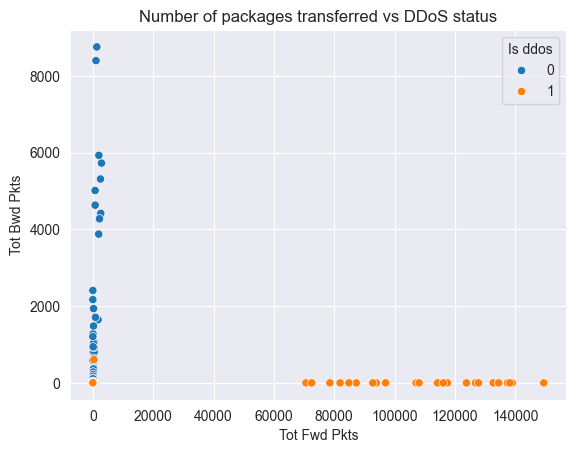

In [91]:
# One of the important parameters should be the number of packages transferred.
# Show the dependence of the DDoS status on the number of sent and obtained packages.
sns.scatterplot(
    x='Tot Fwd Pkts', y='Tot Bwd Pkts',
    hue='Is ddos', data=df.sample(n=100_000, random_state=0)
)
plt.title('Number of packages transferred vs DDoS status')
plt.show()

In [92]:
def get_cross_net_classes_vs_ddos(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """Return cross tabulation of network classes and DDoS status."""
    classes = dataframe[column_name].str\
                                    .split('.', n=1, expand=True)[0]\
                                    .astype('uint8')
    classes = pd.cut(classes,
                     bins=[0, 127, 191, 223, 239, np.inf],
                     labels=['A', 'B', 'C', 'D', 'E'],
                     include_lowest=True)
    cross_tab = pd.crosstab(index=classes,
                            columns=dataframe['Is ddos'],
                            rownames=['Class', ])
    return cross_tab.stack().reset_index().rename(columns={0: 'Amount'})

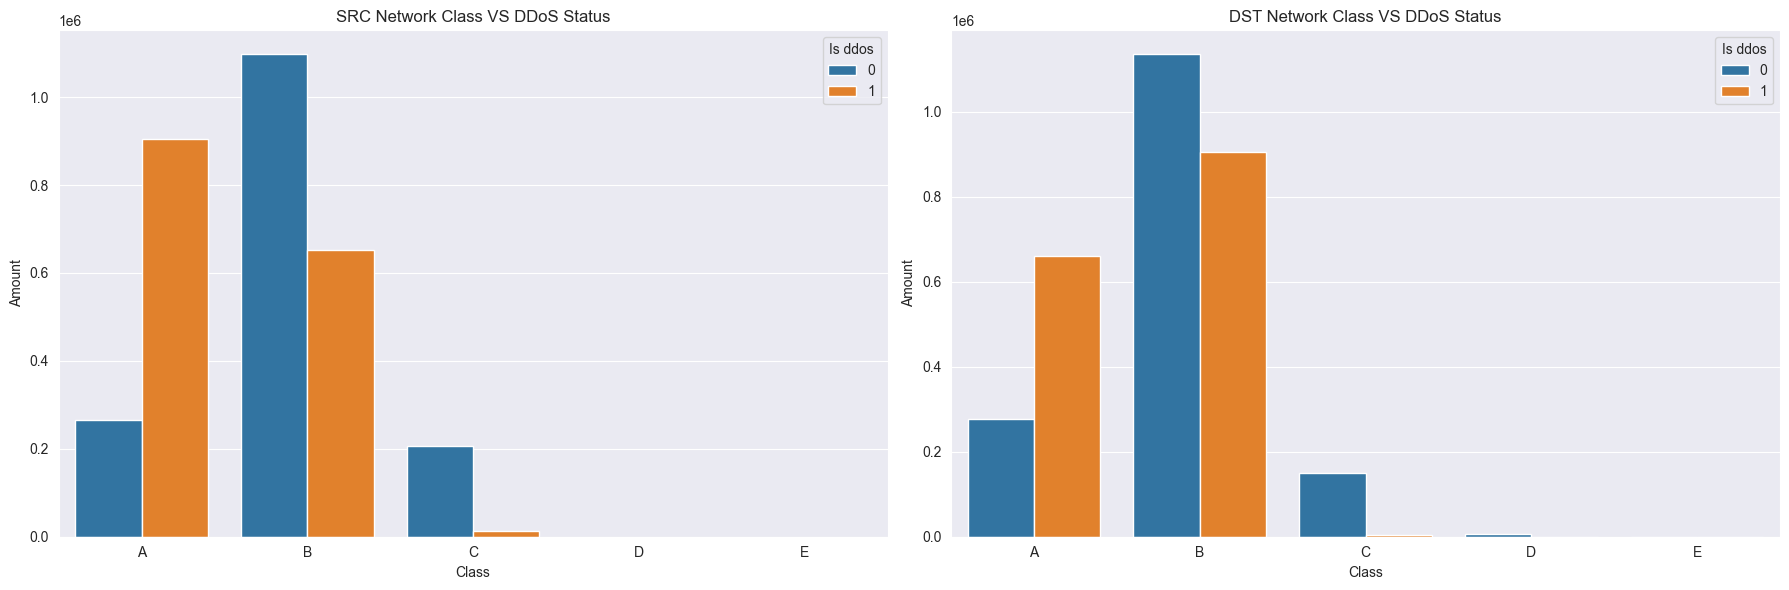

In [93]:
# Show the dependence of the DDoS status on the network class.
cross_src = get_cross_net_classes_vs_ddos(df, 'Src IP')
cross_dst = get_cross_net_classes_vs_ddos(df, 'Dst IP')

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=cross_src['Class'], y=cross_src['Amount'], hue=cross_src['Is ddos'])
plt.title('SRC Network Class VS DDoS Status')

plt.subplot(1, 2, 2)
sns.barplot(x=cross_dst['Class'], y=cross_dst['Amount'], hue=cross_dst['Is ddos'])
plt.title('DST Network Class VS DDoS Status')

plt.tight_layout()
plt.show()

In [94]:
# Remove over-correlated features (corr >= THRESHOLD).
THRESHOLD = 0.9

# Get correlation.
corr_matrix = df.select_dtypes(include=[np.number, ]).corr()
over_correlated = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        correlation = abs(corr_matrix.iloc[i, j])
        if correlation > THRESHOLD:
            over_correlated.append([
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                correlation
            ])

# Show over-correlated features.
cols_to_drop = set()
print('Over-correlated features:')
for c1, c2, corr in over_correlated:
    print(f'[{corr:.2%}] \t`{c1}` ~= `{c2}`')
    cols_to_drop.add(c2)

# Remove them.
df = df.drop(columns=cols_to_drop)
print(f'\nDropped: {cols_to_drop}')

del over_correlated
del cols_to_drop

print('\nAfter:\n', get_df_info_str(df))

Over-correlated features:
[99.34%] 	`TotLen Fwd Pkts` ~= `Tot Fwd Pkts`
[98.56%] 	`TotLen Bwd Pkts` ~= `Tot Bwd Pkts`
[94.84%] 	`Fwd Pkt Len Mean` ~= `Fwd Pkt Len Max`
[97.39%] 	`Fwd Pkt Len Std` ~= `Fwd Pkt Len Max`
[96.51%] 	`Fwd Pkt Len Std` ~= `Fwd Pkt Len Mean`
[96.72%] 	`Bwd Pkt Len Std` ~= `Bwd Pkt Len Max`
[98.27%] 	`Flow IAT Min` ~= `Flow IAT Mean`
[97.51%] 	`Fwd IAT Tot` ~= `Flow Duration`
[97.29%] 	`Fwd IAT Mean` ~= `Flow IAT Mean`
[95.35%] 	`Fwd IAT Mean` ~= `Flow IAT Min`
[92.83%] 	`Fwd IAT Max` ~= `Flow IAT Max`
[97.08%] 	`Fwd IAT Min` ~= `Flow IAT Mean`
[97.89%] 	`Fwd IAT Min` ~= `Flow IAT Min`
[97.49%] 	`Fwd IAT Min` ~= `Fwd IAT Mean`
[98.52%] 	`Fwd Header Len` ~= `Tot Fwd Pkts`
[96.04%] 	`Fwd Header Len` ~= `TotLen Fwd Pkts`
[99.99%] 	`Bwd Header Len` ~= `Tot Bwd Pkts`
[98.55%] 	`Bwd Header Len` ~= `TotLen Bwd Pkts`
[97.58%] 	`Pkt Len Std` ~= `Pkt Len Max`
[99.38%] 	`Pkt Size Avg` ~= `Pkt Len Mean`
[94.84%] 	`Fwd Seg Size Avg` ~= `Fwd Pkt Len Max`
[100.00%] 	`Fwd Seg S

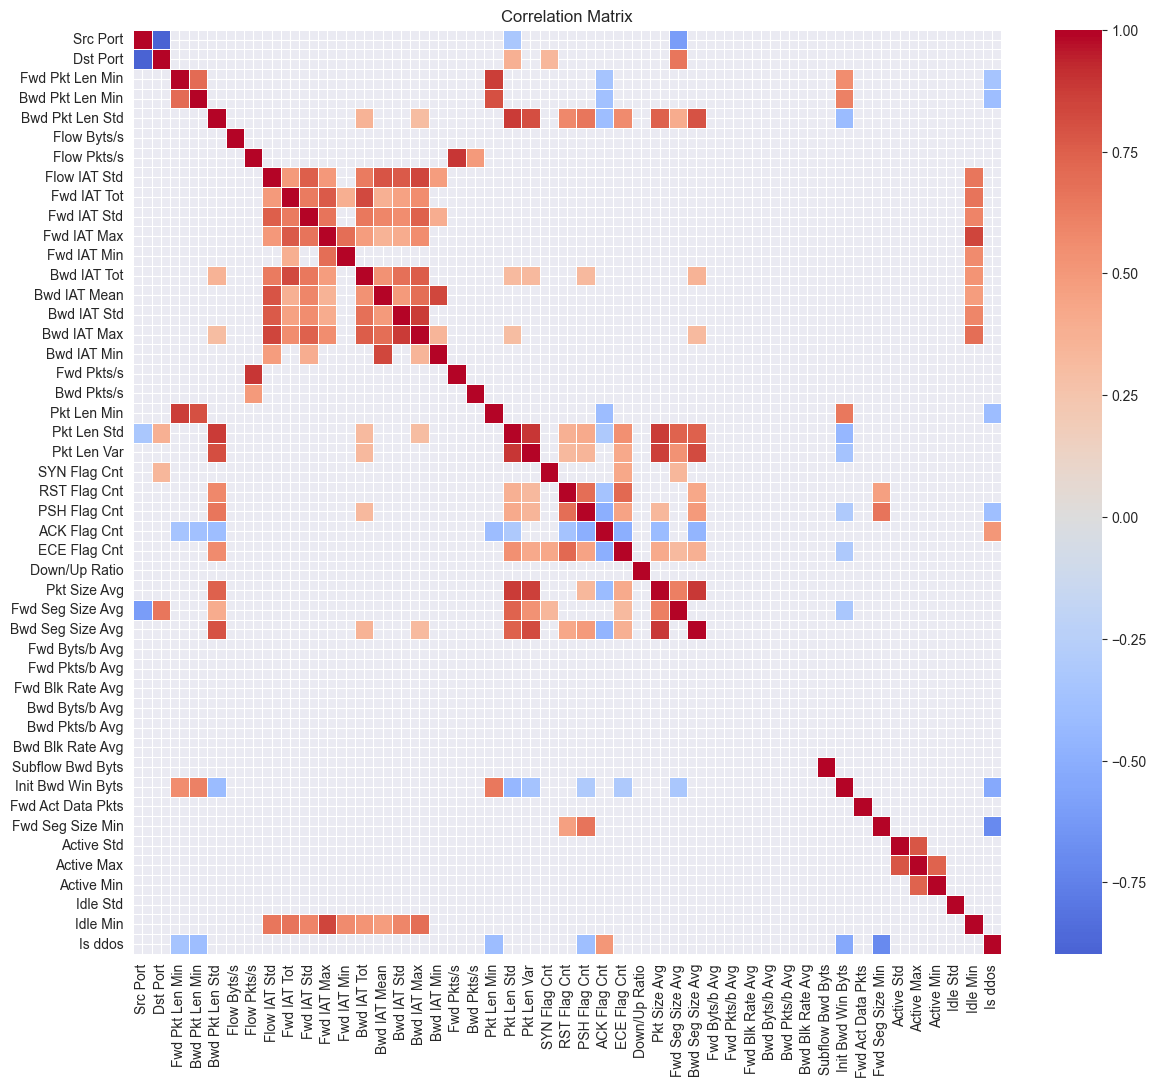

,Src Port,Dst Port,Fwd Pkt Len Min,Bwd Pkt Len Min,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Std,Fwd IAT Tot,Fwd IAT Std,...,Subflow Bwd Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Std,Active Max,Active Min,Idle Std,Idle Min,Is ddos
Src Port,1.000000,-0.896689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dst Port,-0.896689,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fwd Pkt Len Min,NaN,NaN,1.000000,0.707324,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.558148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.355095
Bwd Pkt Len Min,NaN,NaN,0.707324,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.608436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.401625
Bwd Pkt Len Std,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.416606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flow Byts/s,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flow Pkts/s,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flow IAT Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.492796,0.752795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.656939,NaN
Fwd IAT Tot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.492796,1.000000,0.631954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.665818,NaN
Fwd IAT Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.752795,0.631954,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593823,NaN


In [95]:
# Show correlation.
THRESHOLD = 0.3  # Set THRESHOLD = 0 if no filtration needed.

corr_matrix = df.select_dtypes(include=[np.number, ]).corr()
corr_matrix = corr_matrix.mask(abs(corr_matrix) < THRESHOLD, np.nan)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
corr_matrix

## Modeling.

### Preparation.

In [96]:
# Timer.
from timeit import default_timer as timer

# Preprocessing.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML Classifiers.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics.
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score,
)

In [97]:
def show_metrics(test, pred):
    """Display confusion matrix and metrics (accuracy, precision, recall, f1, roc)."""
    # Confusion matrix plot.
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute metrics.
    get_rounded = lambda x: round(x, 100)
    accuracy = get_rounded(accuracy_score(test, pred))
    precision = get_rounded(precision_score(test, pred))
    recall = get_rounded(recall_score(test, pred))
    f1 = get_rounded(f1_score(test, pred))
    roc = get_rounded(roc_auc_score(test, pred))

    # Show metrics as table.
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
        'Score': [accuracy, precision, recall, f1, roc]
    })
    print(metrics_df.to_string(index=False))

In [98]:
def ip_str_to_int(ip: str) -> int:
    """Return integer representation of IP address."""
    octets = list(map(int, ip.split('.')))
    return sum((octet << 8 * (3-ind)) for ind, octet in enumerate(octets))

In [99]:
df['Src IP'] = df['Src IP'].apply(ip_str_to_int)
df['Dst IP'] = df['Dst IP'].apply(ip_str_to_int)
df['Protocol'] = df['Protocol'].astype('category').cat.codes
df['Timestamp'] = df['Timestamp'].apply(lambda t: t.timestamp())

In [100]:
# Split data.
DF_SAMPLE_SIZE = 0.05  # Use only part of the data.
TEST_SIZE = 0.3        # Split data into train and test sets.

df_sample = df.sample(frac=DF_SAMPLE_SIZE, random_state=0)
df_sample = df_sample.drop_duplicates()
df_sample = df_sample.drop(['Timestamp'], axis=1)

x, y = df_sample.drop(TARGET_COL, axis=1), df_sample[TARGET_COL]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=TEST_SIZE, random_state=0
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(f'Using {DF_SAMPLE_SIZE:.0%} of the data\n'
      f'Train size: {len(x_train)}\n'
      f' Test size: {len(x_test)}\n'
      f'DF sample shape:\n{get_df_info_str(df_sample)}\n'
      f'Class balance:\n{y_train.value_counts(normalize=True)}')

Using 5% of the data
Train size: 109799
 Test size: 47058
DF sample shape:
	 Shape: (156857, 50)
	Memory: 29.62 MB
Class balance:
Is ddos
1    0.500105
0    0.499895
Name: proportion, dtype: float64


### kNN.

In [101]:
# Get best model without optimizations and parallelization.

# Skip k<=2 to make the model more stable.
K_RANGE = range(1, 8+1)
get_knn = lambda n_neighbors: KNeighborsClassifier(n_neighbors=n_neighbors)

scores_by_k = []  # Save scores for all the models.
knn = None  # Here will be saved the best model.
print(f'Learning...\nProgress: 0 / {K_RANGE.stop-1}', end='\r')
time_total_start = timer()
for k in K_RANGE:
    time_current_start = timer()

    knn = get_knn(k)
    knn.fit(x_train, y_train)
    knn_pred = knn.predict(x_test)
    score = accuracy_score(y_test, knn_pred)

    scores_by_k.append(score)
    print(f'\tk={k}\tscore={score:.4%} | elapsed={timer()-time_current_start:.0f}s')
    print(f'Progress: {k - K_RANGE.start + 1}/{K_RANGE.stop-K_RANGE.start}', end='\r')

time_knn_slow = timer() - time_total_start
print(f'\nDone. Total time: {time_knn_slow:.0f}s')
del knn, knn_pred, score, time_total_start, time_current_start

Learning...
	k=1	score=99.9235% | elapsed=5s
	k=2	score=99.9129% | elapsed=5s
	k=3	score=99.9001% | elapsed=5s
	k=4	score=99.9086% | elapsed=5s
	k=5	score=99.8852% | elapsed=5s
	k=6	score=99.8874% | elapsed=5s
	k=7	score=99.8831% | elapsed=5s
	k=8	score=99.8895% | elapsed=5s
Progress: 8/8
Done. Total time: 38s


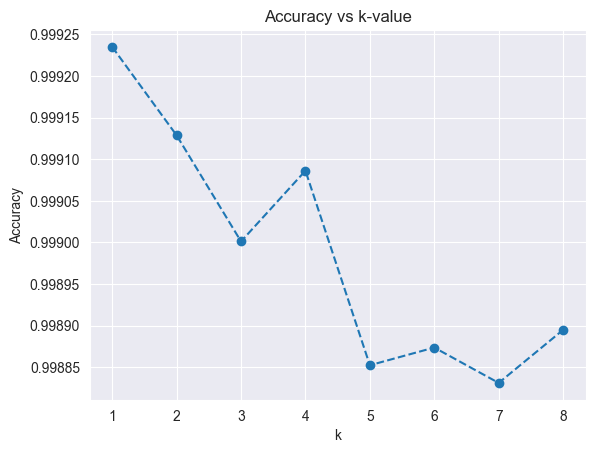

In [102]:
# Show results.
plt.plot(
    K_RANGE, scores_by_k,
    linestyle='dashed', marker='o'
)
plt.xticks(K_RANGE)
plt.title("Accuracy vs k-value")
plt.xlabel("k")
plt.ylabel('Accuracy')
plt.show()

KNN with k=4 results:


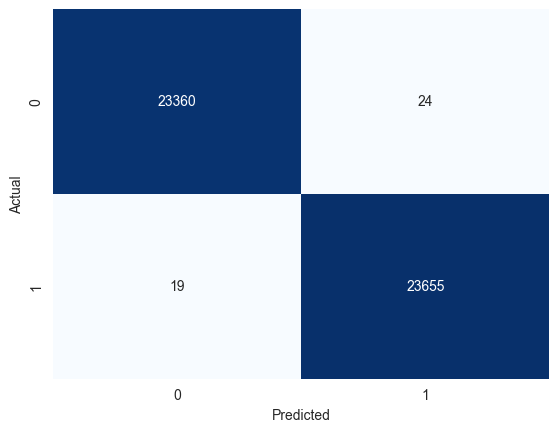

   Metric    Score
 Accuracy 0.999086
Precision 0.998986
   Recall 0.999197
       F1 0.999092
  ROC-AUC 0.999086


In [103]:
# Choose the best model.
k = scores_by_k.index(max(scores_by_k[2:])) + K_RANGE.start
knn = get_knn(k)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)

print(f'KNN with k={k} results:')
show_metrics(y_test, knn_pred)

### Random Forest.

Learning...
Done. Total time: 2s
Random Forest results:


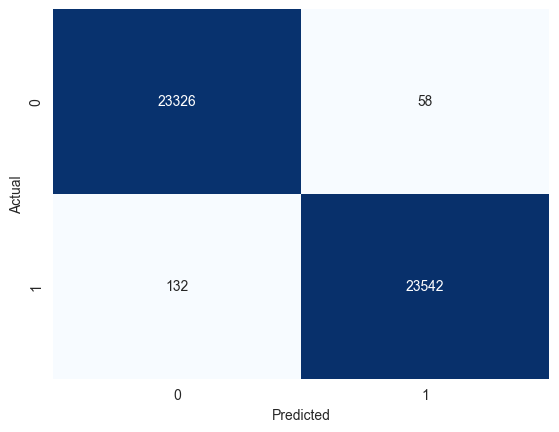

   Metric    Score
 Accuracy 0.995962
Precision 0.997542
   Recall 0.994424
       F1 0.995981
  ROC-AUC 0.995972


In [104]:
time_total_start = timer()
print('Learning...')
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=5,
    max_features='log2',
    random_state=0,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

print(f'Done. Total time: {timer()-time_total_start:.0f}s')
print('Random Forest results:')
show_metrics(y_test, rf_pred)

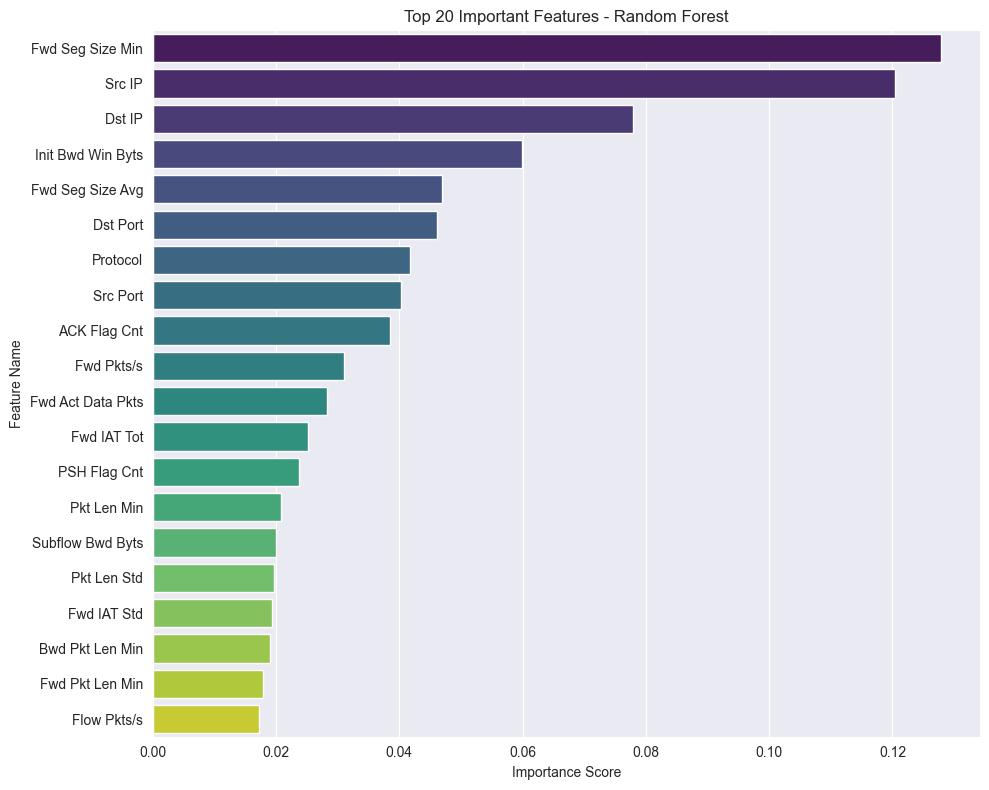

In [105]:
# Show feature importance.
features_df = pd.DataFrame({
    'Feature': df_sample.drop(TARGET_COL, axis=1).columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot the top 20 features.
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20), palette='viridis')
plt.title('Top 20 Important Features - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()